In [1]:
import os
import cv2
import glob
import time
import pickle
import random
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label
%matplotlib inline

In [2]:
def save_p(data, name):
    with open(name, 'wb') as f:
        pickle.dump(data, f)
def load_p(name):
    with open(name, 'rb') as f:
        data = pickle.load(f)
    return data

In [3]:
data=load_p("./data.pickle")

X=data["X"]
Y=data["Y"]
clf=data["clf"]
scaler=data["scaler"]

In [4]:
def plot_2images(img, converted, title1='Original', title2='Converted', cmap="gray", flag1=False, flag2=False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(img)
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(converted, cmap=cmap)
    ax2.set_title(title2, fontsize=30)
    
    if flag1 == True:
        mpimg.imsave("output_images/" + title1, img, format="jpg")
    if flag2 == True:
        mpimg.imsave("output_images/" + title2, converted, format="jpg")

In [5]:
def plot_image(img, title="Original", flag=False, size=(10,10), dpi=100, cmap=None):
    plt.figure(num=None, figsize=size, dpi=dpi, facecolor='w', edgecolor='k')
    if cmap != None:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.title(title)
    
    if flag:
        mpimg.imsave("output_images/" + title, img, format="jpg")

## functions for features extraction

In [6]:
def grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray
    
def hsvscale(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    return hsv

def hlsscale(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return hls

def luvscale(img):
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    return luv

def labscale(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    return lab

def yuvscale(img):
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return yuv

def gaussian_blur(img, kernel_size):
    '''gaussian smoothing'''
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [7]:
def color_space(img, flag="gray"):
    if flag=="gray":
        res=grayscale(img)
    elif flag=="hsv":
        res=hsvscale(img)
    elif flag=="hls":
        res=hlsscale(img)
    elif flag=="luv":
        res=luvscale(img)
    elif flag=="lab":
        res=labscale(img)
    elif flag=="yuv":
        res=yuvscale(img)
    return res

In [8]:
def f_hog(channel, pix_per_cell=16, cell_per_block=2, orient=11, flag=False):
    
    if flag:
        features, hog_image = hog(channel, orientations=orient,
                              pixels_per_cell=(pix_per_cell, pix_per_cell), 
                              cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True, visualise=flag, feature_vector=False,
                                  block_norm="L2-Hys")
        return hog_image, features
    else:
        features = hog(channel, orientations=orient,
                      pixels_per_cell=(pix_per_cell, pix_per_cell), 
                      cells_per_block=(cell_per_block, cell_per_block),
                          transform_sqrt=True, visualise=flag, feature_vector=False,
                          block_norm="L2-Hys")
        return features

In [75]:
vehicle=cv2.imread("./vehicles/vehicles/GTI_Left/image0009.png")

In [76]:
non_vehicle=cv2.imread("./non-vehicles/non-vehicles/GTI/image7.png")

In [78]:
draw_vehicle, f = f_hog(vehicle[:,:,0], flag=True)

In [79]:
draw_non_vehicle, f = f_hog(non_vehicle[:,:,0], flag=True)

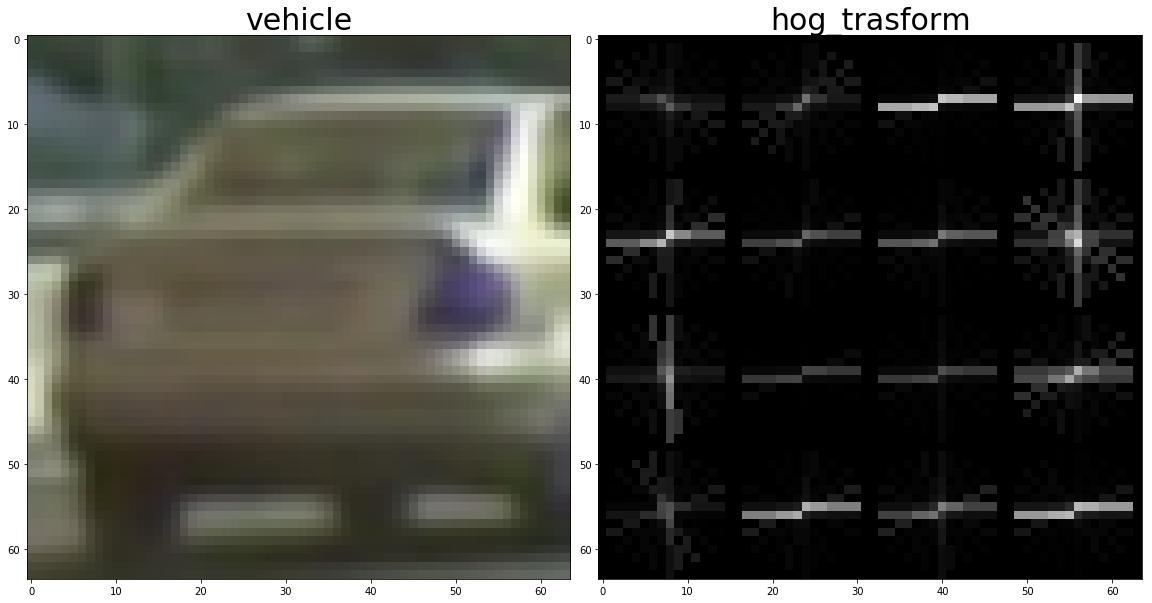

In [84]:
plot_2images(vehicle, draw_vehicle, "vehicle", "hog_trasform")
#plt.savefig("vehicle.jpg")

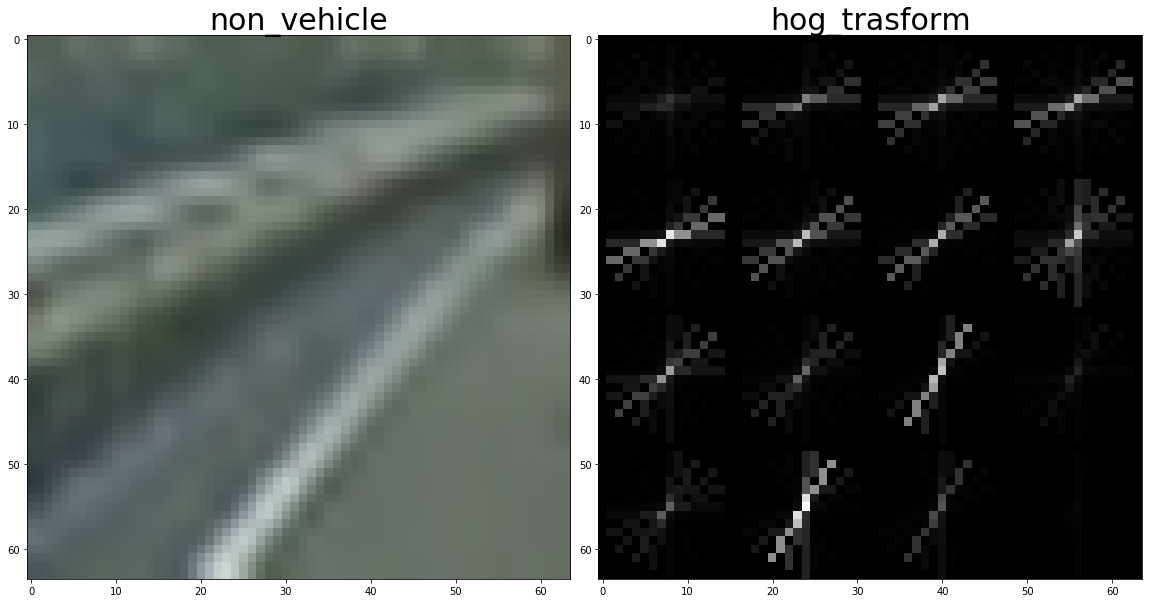

In [86]:
plot_2images(non_vehicle, draw_non_vehicle, "non_vehicle", "hog_trasform")
#plt.savefig("non_vehicle.jpg")

In [88]:
def preprocess(img, scaler, m):
    img_processed=img.copy()
    #img_copy=gaussian_blur(img_copy, 5)
    img_processed=cv2.resize(img_processed, (64, 64)) 
    img_processed=color_space(img_processed, "yuv")
    channels=[img_processed[:,:,0], img_processed[:,:,1], img_processed[:,:,2]]
    features=[]
    for c in channels:
        f = f_hog(c)
        f=f.ravel()
        features.extend(f)
    features=np.array(features[:m])
    features=np.reshape(features, newshape=(1,m))
    features=scaler.transform(features)
    return features

## windows

In [89]:
def compute_windows(boxes, s="s", flag=False):
    
    n, m, _ = img_copy.shape
    step=0.5
    k = n//2 + 30
    
    if s == "s":
        size=n//10
        n_y= (k // size)
        n_x= (m // size)
        range_y=[0.0,1.0,2.0] 
        range_x=[i for i in np.arange(5, n_x, step)]
    elif s == "m":
        size=n//8
        n_y= (k // size)
        n_x= (m // size)
        range_y=[i for i in np.arange(0, n_y, step)] 
        range_x=[i for i in np.arange(2, n_x, step)]
    elif s == "l":
        size=n//6
        n_y= (k // size)
        n_x= (m // size)
        range_y=[i for i in np.arange(0, n_y, step)] 
        range_x=[i for i in np.arange(1, n_x, step)]
        
    if s=="s":
        color=(0,0,255)
    elif s=="m":
        color=(255,0,0)
    elif s=="l":
        color=(0,255,0)
    
    for y in range_y:
        for x in range_x:
            xb, yb = int(x*size), int(k+size*(y+1))
            xu, yu = int(size*(x+1)), int(k+size*(y))
            bottom_left=(xb, yb)
            upper_right=(xu, yu)
            if flag:
                z=cv2.rectangle(img_copy,bottom_left,upper_right,color, 2)
            boxes.append((bottom_left, upper_right))
    return boxes

In [90]:
def collect_windows(img, flag=False):
    boxes = []
    sizes=["s", "m", "l"]
    for s in sizes:
        boxes=compute_windows(boxes, s, flag=flag)
    return boxes

In [91]:
def select_box(img, box):
    xb, yb = box[0]
    xu, yu = box[1]
    img_box=img[yu:yb, xb:xu]
    return img_box

In [92]:
img = mpimg.imread("./test_images/test4.jpg")
n, m, k = img.shape
img_copy = img.copy()
img_copy[:n//2,:,:] = 0

In [93]:
windows=collect_windows(img_copy, flag=True)

In [94]:
img_box=select_box(img_copy, windows[-1])

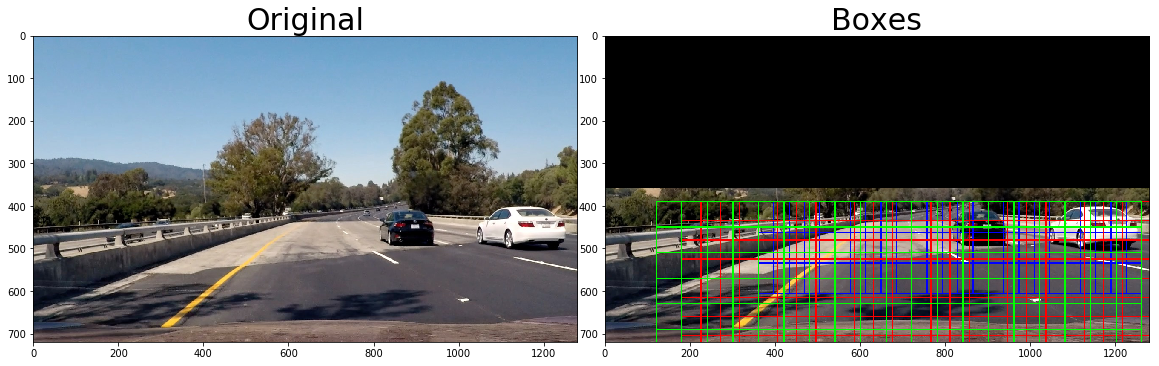

In [95]:
plot_2images(img,img_copy, "Original", "Boxes")
#plt.savefig("boxes.jpg")

## object detection

In [96]:
def f_detection(img, boxes, m=1188, flag=False):
    img_detection=img.copy()
    detections=[]
    for box in boxes:

        img_box=select_box(img_detection, box)
        features=preprocess(img_box, scaler, m)
        p=clf.predict(features)

        if p == 1:
            detections.append(box)
    if flag:
        for d in detections:
            bottom_left=d[0]
            upper_right=d[1]
            z=cv2.rectangle(img_detection,bottom_left,upper_right,(0,0,255), 2)
        return img_detection, detections
    return detections

In [20]:
boxes=collect_windows(img, flag=False)

In [21]:
img_detection, detections=f_detection(img, boxes, flag=True)

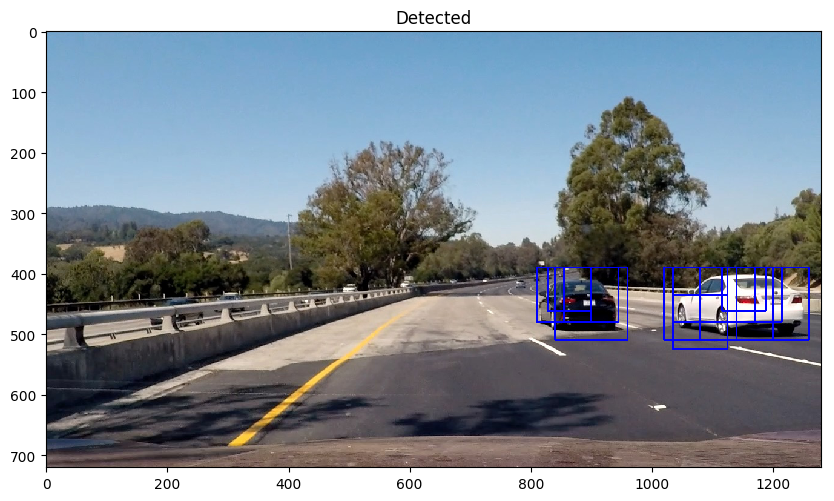

In [23]:
plot_image(img_detection, "Detected")

In [97]:
def add_heat(img, detections, t):
    heatmap = np.zeros_like(img[:,:,0])
    for box in detections:
        xb, yb = box[0]
        xu, yu = box[1]
        ## ((x1, y1), (x2, y2))
        heatmap[yu:yb, xb:xu] += 1
    # Return updated heatmap
    heatmap[heatmap <= t] = 0
    return heatmap

In [98]:
def compute_labels(heatmap, flag=False):
    labels = label(heatmap)
    if flag:
        plot_image(labels[0], cmap='gray')
        
    return labels

In [99]:
heatmap=add_heat(img, detections, 1)

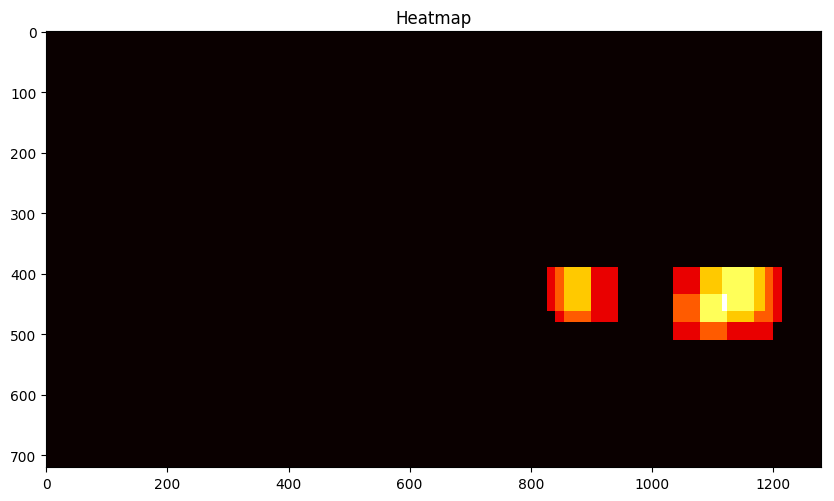

In [100]:
plot_image(heatmap, cmap="hot", title="Heatmap")

In [101]:
labels=compute_labels(heatmap)

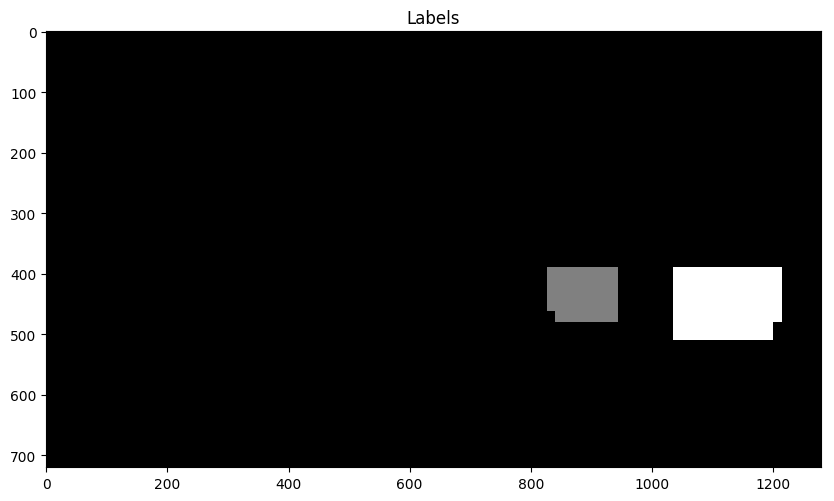

In [102]:
plot_image(labels[0], cmap="gray", title="Labels")

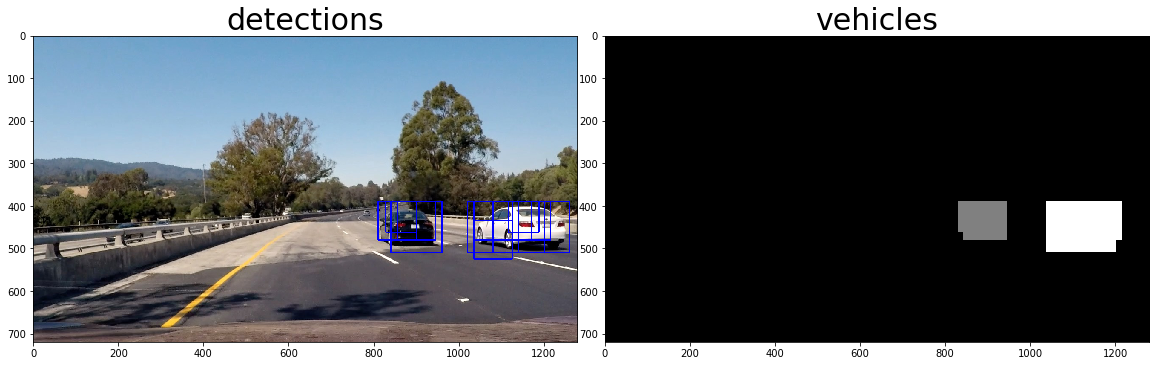

In [104]:
plot_2images(img_detection, labels[0], "detections", "vehicles")
#plt.savefig("detections.jpg")

In [35]:
def compute_boxes(labels):
    boxes=[]
    n=labels[1]
    for i in range(1, n+1):
        nonzero = (labels[0] == i).nonzero()
        nonzero_y = np.array(nonzero[0])
        nonzero_x = np.array(nonzero[1])
        
        bottom_left = (np.min(nonzero_x), np.min(nonzero_y))
        upper_right = (np.max(nonzero_x), np.max(nonzero_y))
        box = (bottom_left, upper_right)
        boxes.append(box)
    return boxes

In [36]:
def draw_boxes(img, boxes):
    for box in boxes:
        cv2.rectangle(img, box[0], box[1], (0,0,255), 6)
    return img

In [37]:
boxes=compute_boxes(labels)

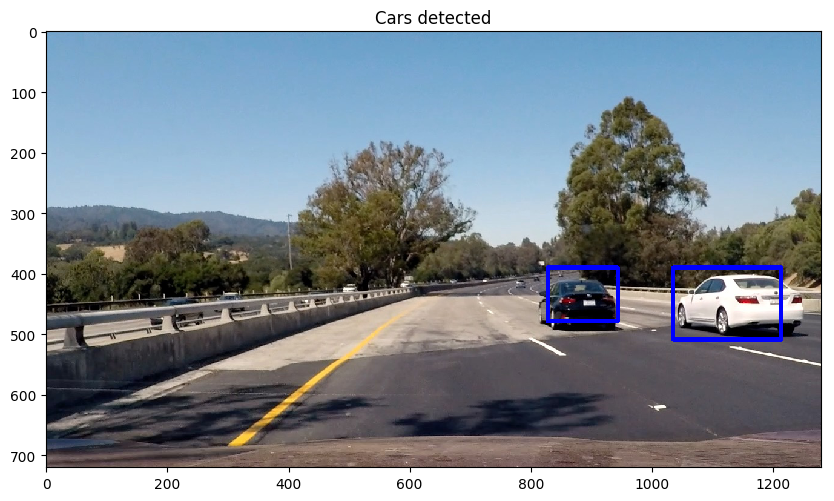

In [39]:
draw_img = draw_boxes(np.copy(img), boxes)
# Display the image
plot_image(draw_img, "Cars detected")

In [106]:
def pipeline(img, flag=False):
    image=img.copy()
    windows=collect_windows(image)
    detections=f_detection(image,windows)
    heatmap=add_heat(img, detections, 0)
    labels=compute_labels(heatmap)
    boxes=compute_boxes(labels)
    
    if flag:
        draw_img = draw_boxes(image, boxes)
        return draw_img, boxes
    
    return boxes

In [59]:
files=os.listdir("./test_images/")

In [60]:
files

['test2.jpg', 'test5.jpg', 'test6.jpg', 'test1.jpg', 'test4.jpg', 'test3.jpg']

In [105]:
def plot_N_images(files, flag=False):

    fig, axs = plt.subplots(len(files), 2, figsize=(20,20))
    fig.subplots_adjust(hspace = .2, wspace=.05)
    for f in range(len(files)):
        file = files[f]
        image = mpimg.imread("./test_images/" + file)
        img=image.copy()
        draw_img, boxes=pipeline(image, True)
        
        axs[f, 0].imshow(image)
        axs[f,1].imshow(draw_img)
        if flag:
            mpimg.imsave("output_images/" + file, result, format="jpg")

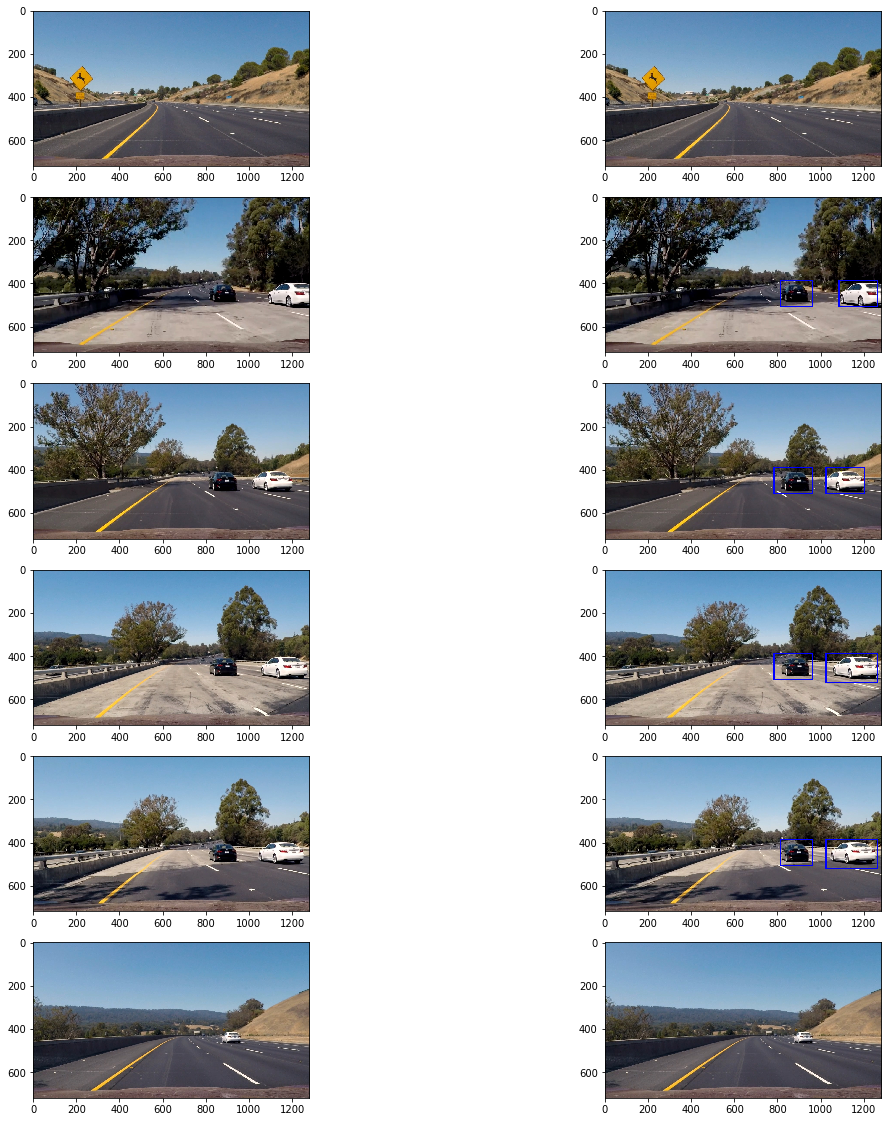

In [107]:
plot_N_images(files)
#plt.savefig("pipeline.jpg")

In [63]:
class Detector:
    
    def __init__(self):
        self.stack_boxes=[]
        self.boxes=[]
        self.n_cars=0
        self.dist=[0]
        
    def get_boxes(self):
        return self.boxes
        
    def distance(self, boxes):
        if len(boxes) == self.n_cars:
            for b in range(len(boxes)):
                x=np.array(boxes[b])
                y=np.array(self.boxes[b])
                self.dist=[]
                if self.boxes is not []:
                    dist = abs(x - y) / y
                    dist = sum(dist) / len(dist)
                    self.dist.append(dist)
                else:
                    self.dist = [0]
        else:
            self.n_cars=len(boxes)
            self.stack_boxes=[]
            self.boxes=[]
                
    def update(self, boxes, t=20, dist=0.25):
        if len(self.stack_boxes) > t:
            self.stack_boxes.pop(0)
        self.distance(boxes)
        ##print(np.mean(self.dist))
        if  np.mean(self.dist) < 0.25:
            self.stack_boxes.append(boxes)
            temp = np.mean(np.array(self.stack_boxes), axis=0)
            temp=temp.astype(int)
            
            self.boxes=[ ( tuple(b[0]), tuple(b[1]) ) for b in temp ]

In [64]:
detector=Detector()

def process_image(image):
    new_image = image.copy()
    boxes=pipeline(new_image)
    
    detector.update(boxes)
    average_boxes=detector.get_boxes()
    
    res = draw_boxes(image, boxes)
    return res

In [65]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [66]:
video_output = 'test_video_output.mp4'
video_input = VideoFileClip('./test_video.mp4')
processed_video = video_input.fl_image(process_image)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [02:30<00:04,  4.03s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 2min 29s, sys: 260 ms, total: 2min 29s
Wall time: 2min 32s


In [67]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [ ]:
# video_output1 = './project_video_output.mp4'
# video_input1 = VideoFileClip('./project_video.mp4')
# processed_video = video_input1.fl_image(process_image)
# %time processed_video.write_videofile(video_output1, audio=False)

In [ ]:
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(video_output1))